In [16]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier




In [17]:
genreAll = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/GenreAll.csv")
for col in genreAll.columns:
    genreAll.rename(columns={col:col.strip()}, inplace = True)
feat_30 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_30_sec.csv")
feat_3 = pd.read_csv("/home/ibroto/Documents/UPF_SMC/ML/Lab1/Lab1/features_3_sec.csv")


## Data Overview

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

scaler = MinMaxScaler()
scaler = preprocessing.StandardScaler()


nrows, ncols = genreAll.shape
print("GenreAll dataset:")
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-2}")
print(f"Nbr of classes: {pd.unique(genreAll.genre).size}")

for col in genreAll.columns:
    if genreAll[col].isna().sum()!=0: print(f"{genreAll[col].isna().sum()} NaN found in col {col}")
    if isinstance(genreAll[col][0], str):
        print(f'  Textual column : {col} (values: {genreAll[col].unique()})')
    else:
        genreAll[col] = scaler.fit_transform(genreAll[[col]])

genreAll.rename(columns={'genre':'label'}, inplace=True) #so that all the datasets have the same solumn name for the label

nrows, ncols = feat_30.shape
print("--------------------------------------------")
print("feature30 dataset:")
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-3}")
print(f"Nbr of classes: {pd.unique(feat_30.label).size}")

for col in feat_30.columns[1:]:
    if isinstance(feat_30[col][0], str): print(f'  Textual column : {col} (values: {feat_30[col].unique()})')
    else:
        feat_30[col] = scaler.fit_transform(feat_30[[col]])

        #feat_30[col] = (feat_30[col]-feat_30[col].min())/(feat_30[col].max()-feat_30[col].min())


nrows, ncols = feat_3.shape
print("--------------------------------------------")
print("feature3 dataset:")
print(f"Nbr of observations: {nrows-1}\nNbr of features: {ncols-3}")
print(f"Nbr of classes: {pd.unique(feat_3.label).size}")
for col in feat_3.columns[1:]:
    if isinstance(feat_3[col][0], str): print(f'  Textual column : {col} (values: {feat_3[col].unique()})')
    else:
        feat_3[col] = scaler.fit_transform(feat_3[[col]])

        #feat_3[col] = (feat_3[col]-feat_3[col].min())/(feat_3[col].max()-feat_3[col].min())



GenreAll dataset:
Nbr of observations: 992
Nbr of features: 239
Nbr of classes: 10
  Textual column : highlevel_speech_music_value (values: ['speech' 'music'])
  Textual column : highlevel_voice_instrumental_value (values: ['instrumental' 'voice'])
  Textual column : tonal_key_mode_value (values: ['major' 'minor'])
  Textual column : genre (values: ['blu' 'cla' 'cou' 'dis' 'hip' 'jaz' 'met' 'pop' 'reg' 'roc'])
--------------------------------------------
feature30 dataset:
Nbr of observations: 999
Nbr of features: 57
Nbr of classes: 10
  Textual column : label (values: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'])
--------------------------------------------
feature3 dataset:
Nbr of observations: 9989
Nbr of features: 57
Nbr of classes: 10
  Textual column : label (values: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock'])


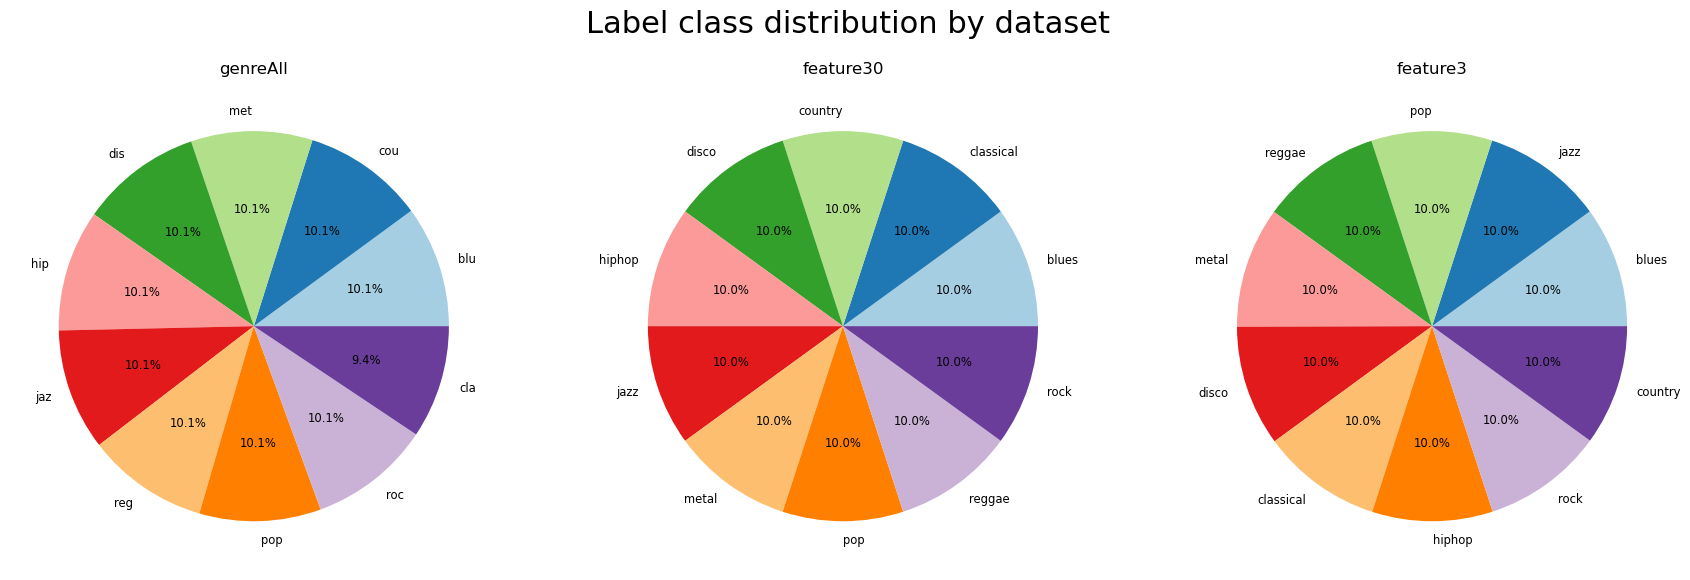

In [19]:
import matplotlib.pyplot as plt

# Example: replace these with your actual DataFrames
datasets = {
    'genreAll': genreAll,
    'feature30': feat_30,
    'feature3': feat_3
    }

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # smaller width makes pies larger

colors = plt.cm.Paired.colors

for ax, (name, df) in zip(axes, datasets.items()):
    count_df = df['label'].value_counts().reset_index()
    count_df.columns = ['values', 'counts']

    ax.pie(count_df['counts'], labels=count_df['values'], autopct='%.1f%%',
           textprops={'size': 'smaller'}, radius=1,
           colors=colors[:len(count_df)])
    ax.set_title(f'{name}')

fig.suptitle('Label class distribution by dataset', fontsize=22)

plt.tight_layout(pad=2.0)
plt.show()


In [20]:

#replace string-valued rows with integers
genre_dict = {'blu':0, 'cla':1, 'cou':2, 'dis':3, 'hip':4, 'jaz':5, 'met':6, 'pop':7, 'reg':8,'roc':9}
highlevel_speech_music_value_dict = {'music':0, 'speech':1}
highlevel_voice_instrumental_value_dict = {'instrumental':0, 'voice':1}
tonal_key_mode_value_dict = {'minor':0, 'major':1}

genreAll['highlevel_speech_music_value'] = genreAll['highlevel_speech_music_value'].replace(highlevel_speech_music_value_dict)
genreAll['highlevel_voice_instrumental_value'] = genreAll['highlevel_voice_instrumental_value'].replace(highlevel_voice_instrumental_value_dict)
genreAll['tonal_key_mode_value'] = genreAll['tonal_key_mode_value'].replace(tonal_key_mode_value_dict)
genreAll['label'] = genreAll['label'].replace(genre_dict)

feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_30['label'] = feat_30['label'].replace(feat_label_dict)

feat_label_dict = {'blues':0, 'classical':1, 'country':2, 'disco':3, 'hiphop':4, 'jazz':5, 'metal':6, 'pop':7, 'reggae':8,'rock':9}
feat_3['label'] = feat_3['label'].replace(feat_label_dict)

## Feature Selection

We have a lot of features. As a rule od thumb, we want to have ten times more data than number of features, which means that at most we would like to have around 100 features. Let's start with that, and later we can play around with this number

In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

featSelector = SelectKBest(f_classif, k=60)
reduced_allGenre = featSelector.fit_transform(genreAll[genreAll.columns[2:-1]],genreAll[genreAll.columns[-1]])
reduced_allGenre = np.concatenate((reduced_allGenre, genreAll[genreAll.columns[-1]].values.reshape(-1, 1)), axis=1)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [96 98] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


## Train-test splits

In [22]:
from sklearn.model_selection import train_test_split
data = {
    'genreAll':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_30':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
    'feat_3':{'X_train':[],'y_train':[],'X_test':[],'y_test':[]},
}


data['genreAll']['X_train'], data['genreAll']['X_test'], data['genreAll']['y_train'], data['genreAll']['y_test'] = train_test_split(reduced_allGenre[:,:-1], reduced_allGenre[:,-1], test_size=0.20)
data['feat_30']['X_train'], data['feat_30']['X_test'], data['feat_30']['y_train'], data['feat_30']['y_test'] = train_test_split(feat_30[feat_30.columns[:-1]], feat_30.label, test_size=0.20)

# Note that features_3.csv contains multiple fragments of the same song
# Fragments of the same song shouldn't be at the same time in the train and test splits
train_filenames = data['feat_30']['X_train'].filename.unique()
test_filenames = data['feat_30']['X_test'].filename.unique()
#now we can get rid of them in the feat30 data
data['feat_30']['X_train'] = data['feat_30']['X_train'][data['feat_30']['X_train'].columns[2:]]
data['feat_30']['X_test'] = data['feat_30']['X_test'][data['feat_30']['X_test'].columns[2:]]

feat_3['original_filename'] = feat_3['filename'].transform(lambda x: x.split('.')[0]+'.'+x.split('.')[1]+'.wav')

data['feat_3']['X_train'] =feat_3[feat_3['original_filename'].isin(train_filenames)][feat_3.columns[2:-2]]
data['feat_3']['y_train'] =feat_3[feat_3['original_filename'].isin(train_filenames)][feat_3.columns[-2]]
data['feat_3']['X_test'] = feat_3[feat_3['original_filename'].isin(test_filenames)][feat_3.columns[2:-2]]
data['feat_3']['y_test'] = feat_3[feat_3['original_filename'].isin(test_filenames)][feat_3.columns[-2]]

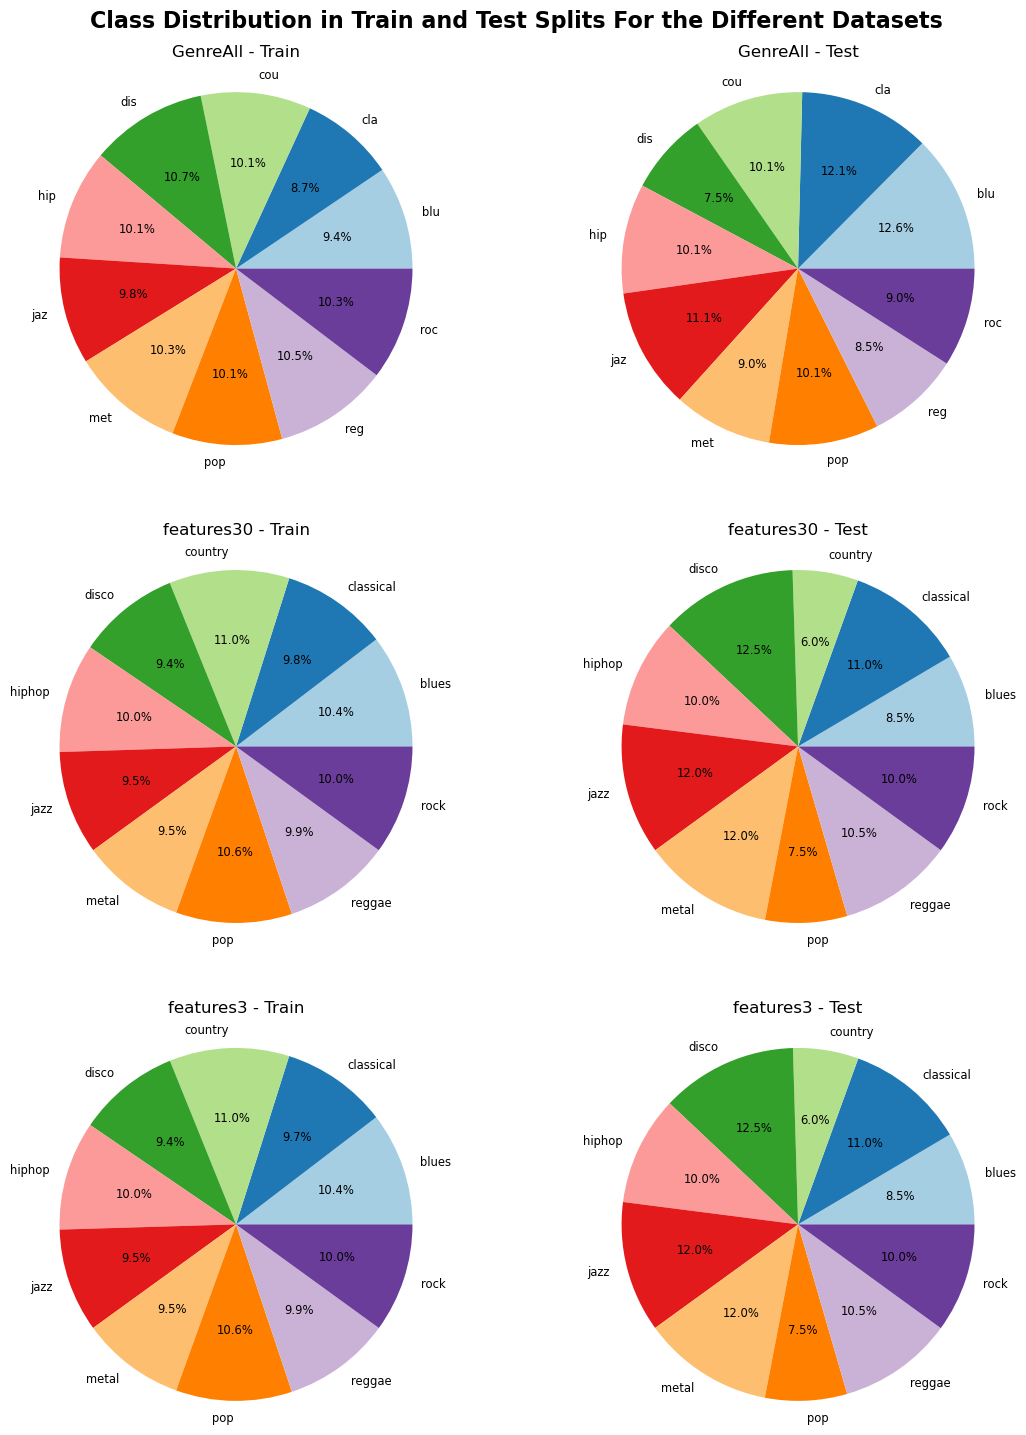

In [23]:
import matplotlib.pyplot as plt

# Invert tag dictionary (int -> string)
inv_genre_dic = {v: k for k, v in genre_dict.items()}
# Invert tag dictionary (int -> string)
inv_feat_label_dict = {v: k for k, v in feat_label_dict.items()}


# Count occurrences from np.array
unique_train, genreAll_train_counts = np.unique(data['genreAll']['y_train'], return_counts=True)
unique_test, genreAll_test_counts = np.unique(data['genreAll']['y_test'], return_counts=True)
# Convert to label names using the inverted map
genreAll_train_labels = [inv_genre_dic[i] for i in unique_train]
genreAll_test_labels = [inv_genre_dic[i] for i in unique_test]

# Count occurrences from pandas
feat30_train_counts = data['feat_30']['y_train'].value_counts().sort_index()
feat30_test_counts = data['feat_30']['y_test'].value_counts().sort_index()
# Convert to label names using the inverted map
feat30_train_labels = [inv_feat_label_dict[i] for i in feat30_train_counts.index]
feat30_test_labels = [inv_feat_label_dict[i] for i in feat30_test_counts.index]

# Count occurrences from pandas
feat3_train_counts = data['feat_3']['y_train'].value_counts().sort_index()
feat3_test_counts = data['feat_3']['y_test'].value_counts().sort_index()
# Convert to label names using the inverted map
feat3_train_labels = [inv_feat_label_dict[i] for i in feat3_train_counts.index]
feat3_test_labels = [inv_feat_label_dict[i] for i in feat3_test_counts.index]

datasets = [
    ("GenreAll", genreAll_train_counts, genreAll_test_counts, genreAll_train_labels, genreAll_test_labels),
    ("features30", feat30_train_counts, feat30_test_counts, feat30_train_labels, feat30_test_labels),
    ("features3", feat3_train_counts, feat3_test_counts, feat3_train_labels, feat3_test_labels)
]

colors = plt.cm.Paired.colors

fig, axes = plt.subplots(3, 2, figsize=(12, 15))  # 3 rows × 2 columns

for i, (name, train_counts, test_counts, train_labels, test_labels) in enumerate(datasets):
    # --- Train pie (left column) ---
    axes[i, 0].pie(
        train_counts,
        autopct='%1.1f%%',
        labels=train_labels,
        colors=colors[:len(train_labels)],
        radius=1.2,
        textprops={'size': 'smaller'}
    )
    axes[i, 0].set_title(f'{name} - Train',pad=20)

    # --- Test pie (right column) ---
    axes[i, 1].pie(
        test_counts,
        autopct='%1.1f%%',
        labels=test_labels,
        colors=colors[:len(test_labels)],
        radius=1.2,
        textprops={'size': 'smaller'}
    )
    axes[i, 1].set_title(f'{name} - Test',pad=20)

# Global title and layout tweaks
fig.suptitle('Class Distribution in Train and Test Splits For the Different Datasets', fontsize=16, fontweight='bold')
plt.tight_layout(pad=4.0)
plt.subplots_adjust(hspace=0.3, top=0.93)
plt.show()


## Logistic Regression

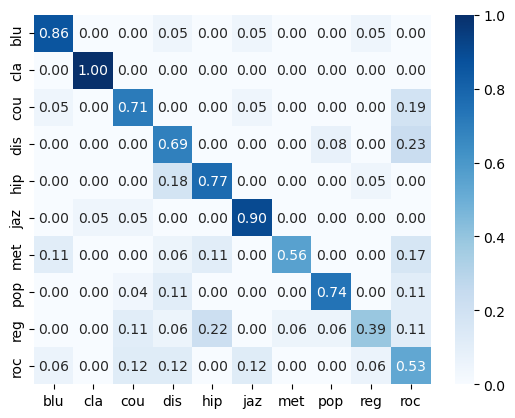

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

X_train = data['feat_30']['X_train']
y_train = data['feat_30']['y_train']
X_test = data['feat_30']['X_test']
y_test = data['feat_30']['y_test']

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

label_names = [i for i in genre_dict.keys()]
singleClass_cm = multilabel_confusion_matrix(y_test, y_pred,
                            labels=genreAll.label.unique()) #tn, fn, fp, tp

cm = confusion_matrix(y_test, y_pred,
                            labels=genreAll.label.unique(), normalize='true') #tn, fn, fp, tp
df_cfm = pd.DataFrame(cm, index=label_names, columns=label_names)
cfm_plot = sn.heatmap(df_cfm,annot=df_cfm,fmt=".2f",cmap="Blues")



In [11]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
kf = KFold(n_splits=10)
score = cross_val_score(clf, X_train,y_train, cv=kf)
#score = cross_validate(clf, X_train,y_train, cv=kf, scoring=['accuracy', 'f1_micro'])
print(f"Avg acc: {score.mean()}, avg sd: {score.std()}")


Avg acc: 0.70125, avg sd: 0.040869456810679536


## k-Nearest Neigbours

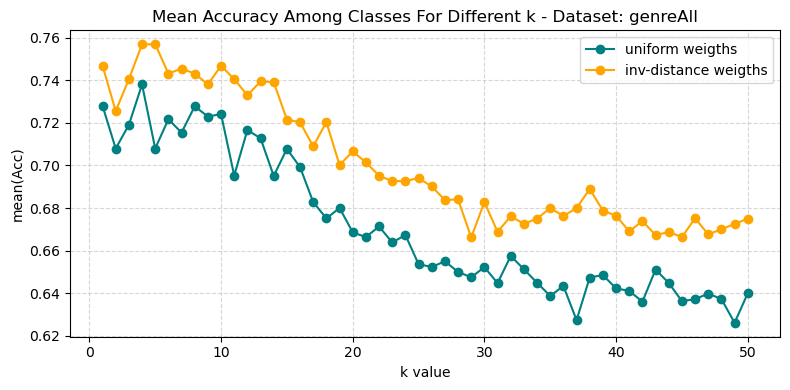

Best AccScore for uniformly weigthed distances: 0.7380 ± 0.0443 (k = 4)
Best AccScore for inv-dist weigthed distances: 0.7569 ± 0.0464 (k = 5)


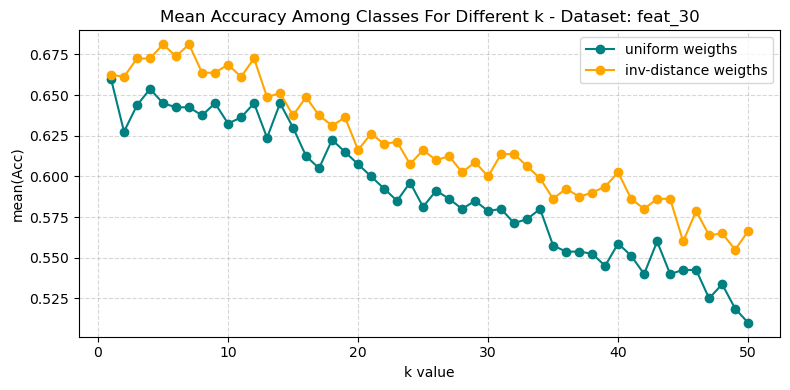

Best AccScore for uniformly weigthed distances: 0.6600 ± 0.0418 (k = 1)
Best AccScore for inv-dist weigthed distances: 0.6813 ± 0.0440 (k = 5)


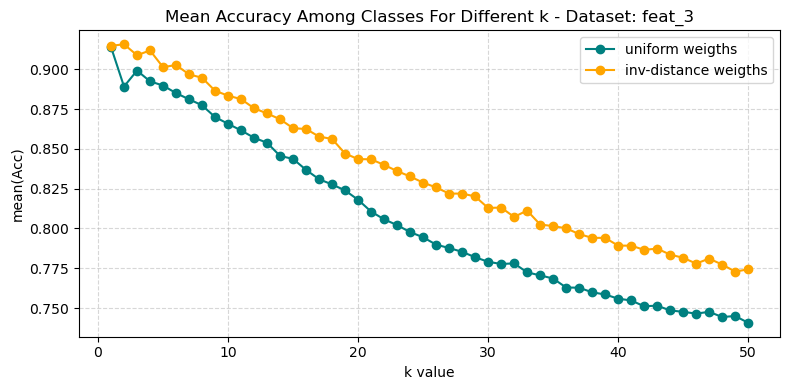

Best AccScore for uniformly weigthed distances: 0.9139 ± 0.0122 (k = 1)
Best AccScore for inv-dist weigthed distances: 0.9156 ± 0.0113 (k = 2)


In [9]:
from sklearn.neighbors import KNeighborsClassifier

kf = KFold(n_splits=10, shuffle=True)


for dataset in data.keys():
    avg_acc_kn = []
    std_acc_kn = []
    avg_acc_kn_dist = []
    std_acc_kn_dist = []
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']
    for k in range(1,51,1):
    #uniform distance
        neigh = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(neigh, X_train,y_train, cv=kf)
        avg_acc_kn.append(scores.mean())
        std_acc_kn.append(scores.std())
    #inv-distnace
        neigh = KNeighborsClassifier(n_neighbors=k, weights='distance') #weight points by the inverse of their distance
        scores = cross_val_score(neigh, X_train,y_train, cv=kf)
        avg_acc_kn_dist.append(scores.mean())
        std_acc_kn_dist.append(scores.std())

    plt.figure(figsize=(8, 4))
    plt.plot(range(1,51,1),avg_acc_kn,'o-', color='teal', label='uniform weigths')
    plt.plot(range(1,51,1),avg_acc_kn_dist,'o-', color='orange', label='inv-distance weigths')
    plt.title(f"Mean Accuracy Among Classes For Different k - Dataset: {dataset}")
    plt.xlabel("k value")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    data[dataset]['best_k'] = np.argmax(avg_acc_kn)+1 if max(avg_acc_kn)>max(avg_acc_kn_dist) else np.argmax(avg_acc_kn_dist)+1
    print(f"Best AccScore for uniformly weigthed distances: {max(avg_acc_kn):.4f} ± {std_acc_kn[np.argmax(avg_acc_kn)]:.4f} (k = {np.argmax(avg_acc_kn)+1})")
    print(f"Best AccScore for inv-dist weigthed distances: {max(avg_acc_kn_dist):.4f} ± {std_acc_kn_dist[np.argmax(avg_acc_kn)]:.4f} (k = {np.argmax(avg_acc_kn_dist)+1})")



## Desicion trees

In [10]:
clf = tree.DecisionTreeClassifier()
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']

    clf = tree.DecisionTreeClassifier(criterion='gini')
    scores_gini = cross_val_score(clf, X_train,y_train, cv=kf)
    clf = tree.DecisionTreeClassifier(criterion='entropy')
    scores_entropy = cross_val_score(clf, X_train,y_train, cv=kf)
    clf = tree.DecisionTreeClassifier(criterion='log_loss')
    scores_log_loss = cross_val_score(clf, X_train,y_train, cv=kf)
    print("Dataset:", dataset)
    print(f"Avg AccScore for gini criterion: {scores_gini.mean():.4f} ± {scores_gini.std():.4f}")
    print(f"Avg AccScore for entropy criterion: {scores_entropy.mean():.4f} ± {scores_entropy.std():.4f}")
    print(f"Avg AccScore for log_loss criterion: {scores_log_loss.mean():.4f} ± {scores_log_loss.std():.4f}")
    print('----------------------------------------------------------\n')




Dataset: genreAll
Avg AccScore for gini criterion: 0.5681 ± 0.0644
Avg AccScore for entropy criterion: 0.5919 ± 0.0492
Avg AccScore for log_loss criterion: 0.6233 ± 0.0334
----------------------------------------------------------

Dataset: feat_30
Avg AccScore for gini criterion: 0.4688 ± 0.0531
Avg AccScore for entropy criterion: 0.5075 ± 0.0430
Avg AccScore for log_loss criterion: 0.5375 ± 0.0440
----------------------------------------------------------

Dataset: feat_3
Avg AccScore for gini criterion: 0.6641 ± 0.0185
Avg AccScore for entropy criterion: 0.6762 ± 0.0185
Avg AccScore for log_loss criterion: 0.6850 ± 0.0113
----------------------------------------------------------



## Random Forest

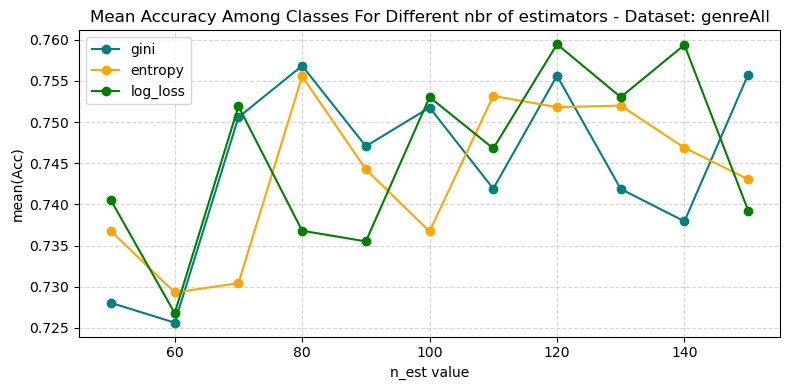

Dataset: genreAll
Best AccScore for gini criterion: 0.7569 ± 0.0524 (nbr_est = 80)
Best AccScore for entropy criterion: 0.7556 ±0.0418  (nbr_est = 80)
Best AccScore for log_loss criterion: 0.7595 ± 0.0600 (nbr_est = 120)
----------------------------------------------------------



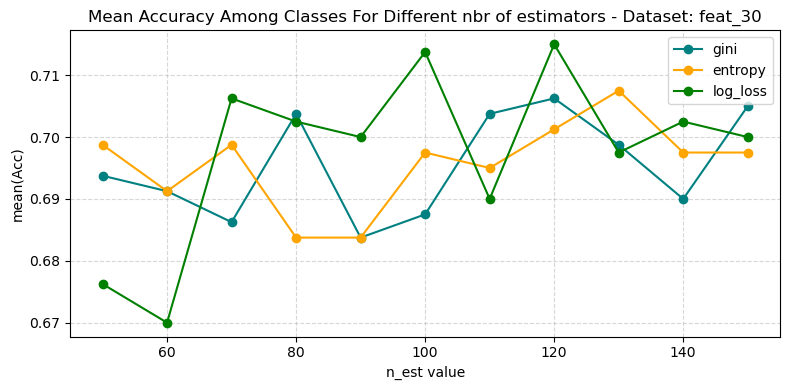

Dataset: feat_30
Best AccScore for gini criterion: 0.7063 ± 0.0475 (nbr_est = 120)
Best AccScore for entropy criterion: 0.7075 ±0.0475  (nbr_est = 130)
Best AccScore for log_loss criterion: 0.7150 ± 0.0524 (nbr_est = 120)
----------------------------------------------------------



KeyboardInterrupt: 

In [11]:
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    std_acc_gini = []
    avg_acc_gini = []
    std_acc_entropy = []
    avg_acc_entropy = []
    std_acc_log_loss = []
    avg_acc_log_loss = []


    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']
    for n_est in range(50,151,10):
    #gini:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='gini')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_gini.append(scores.mean())
        std_acc_gini.append(scores.std())
    #entropy:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='entropy')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_entropy.append(scores.mean())
        std_acc_entropy.append(scores.std())
    #log_loss:
        clf = RandomForestClassifier(n_estimators=n_est,criterion='log_loss')
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc_log_loss.append(scores.mean())
        std_acc_log_loss.append(scores.std())


    plt.figure(figsize=(8, 4))
    plt.plot(range(50,151,10),avg_acc_gini,'o-', color='teal', label='gini')
    plt.plot(range(50,151,10),avg_acc_entropy,'o-', color='orange', label='entropy')
    plt.plot(range(50,151,10),avg_acc_log_loss,'o-', color='green', label='log_loss')

    plt.title(f"Mean Accuracy Among Classes For Different nbr of estimators - Dataset: {dataset}")
    plt.xlabel("n_est value")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()
    #data[dataset]['best_k'] = np.argmax(avg_acc_kn)+1 if max(avg_acc_kn)>max(avg_acc_kn_dist) else np.argmax(avg_acc_kn_dist)+1
    print("Dataset:", dataset)
    print(f"Best AccScore for gini criterion: {max(avg_acc_gini):.4f} ± {std_acc_gini[np.argmax(avg_acc_gini)]:.4f} (nbr_est = {np.argmax(avg_acc_gini)*10+50})")
    print(f"Best AccScore for entropy criterion: {max(avg_acc_entropy):.4f} ±{std_acc_entropy[np.argmax(avg_acc_entropy)]:.4f}  (nbr_est = {np.argmax(avg_acc_entropy)*10+50})")
    print(f"Best AccScore for log_loss criterion: {max(avg_acc_log_loss):.4f} ± {std_acc_log_loss[np.argmax(avg_acc_log_loss)]:.4f} (nbr_est = {np.argmax(avg_acc_log_loss)*10+50})")
    print('----------------------------------------------------------\n')



## Multi Layer Perceptron

/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

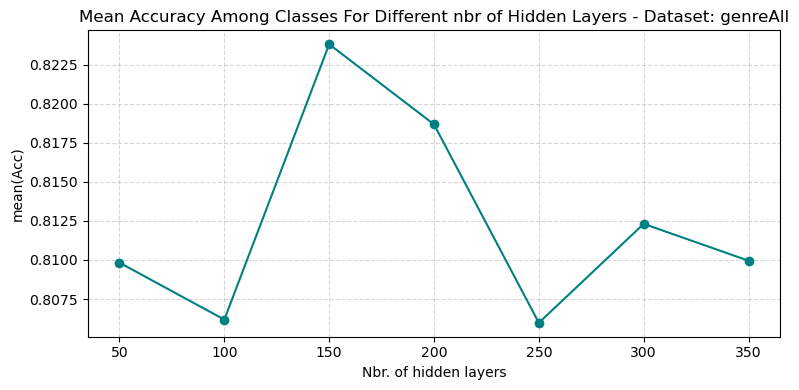

Dataset: genreAll
Best AccScore for gini criterion: 0.8238 ± 0.0273 (nbr. hidden layers = 150)
----------------------------------------------------------



/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

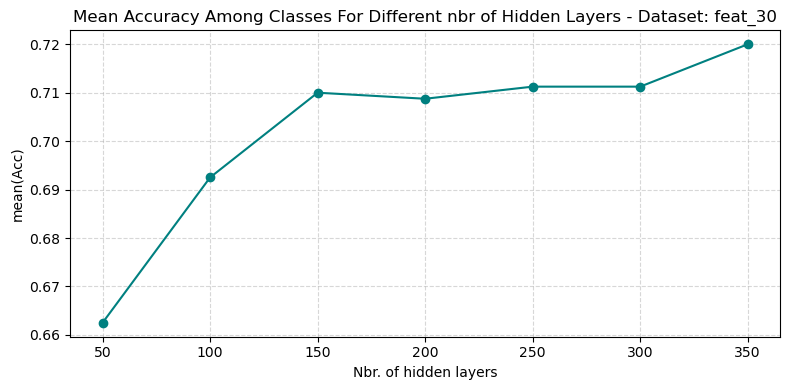

Dataset: feat_30
Best AccScore for gini criterion: 0.7200 ± 0.0396 (nbr. hidden layers = 350)
----------------------------------------------------------



/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the 

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

for dataset in data.keys():
    std_acc = []
    avg_acc = []

    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']

    for hidd_layers in range(50,351,50):
        clf = MLPClassifier(hidden_layer_sizes=hidd_layers, max_iter=300)
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        avg_acc.append(scores.mean())
        std_acc.append(scores.std())


    plt.figure(figsize=(8, 4))
    plt.plot(range(50,351,50),avg_acc,'o-', color='teal')

    plt.title(f"Mean Accuracy Among Classes For Different nbr of Hidden Layers - Dataset: {dataset}")
    plt.xlabel("Nbr. of hidden layers")
    plt.ylabel("mean(Acc)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    data[dataset]['best_hid_layers'] = (np.argmax(avg_acc)+1)*50
    print("Dataset:", dataset)
    print(f"Best AccScore for MLP: {max(avg_acc):.4f} ± {std_acc[np.argmax(avg_acc)]:.4f} (nbr. hidden layers = {(np.argmax(avg_acc)+1)*50})")
    print('----------------------------------------------------------\n')



## general loop

In [24]:

classifiers = [
    LogisticRegression(random_state=0, max_iter=300),
    KNeighborsClassifier(n_neighbors=4, weights='distance'), #weight points by the inverse of their distance
    tree.DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=10, random_state=0),
    MLPClassifier(random_state=1, max_iter=500)
]

kf = KFold(n_splits=10, shuffle=True)
avg_acc = []
std_acc = []
models = ['LogisticRegression', 'k-NN', 'Desicion Tree', 'Random Forest', 'MLP']

for dataset in data.keys():
    X_train = data[dataset]['X_train']
    y_train = data[dataset]['y_train']
    X_test = data[dataset]['X_test']
    y_test = data[dataset]['y_test']
    data[dataset]['train_scores'] = {
        'std': [], 'avg': []
        }
    data[dataset]['test_scores'] = []
    for clf, model in zip(classifiers, models):
        print(clf)
        scores = cross_val_score(clf, X_train,y_train, cv=kf)
        data[dataset]['train_scores']['avg'].append(scores.mean())
        data[dataset]['train_scores']['std'].append(scores.std())

        clf.fit(X_train, y_train)
        data[dataset]['test_scores'].append(clf.score(X_test,y_test))



LogisticRegression(max_iter=300, random_state=0)
0.7889447236180904
KNeighborsClassifier(n_neighbors=4, weights='distance')
0.7487437185929648
DecisionTreeClassifier()
0.5979899497487438
RandomForestClassifier(max_depth=10, random_state=0)
0.7336683417085427
MLPClassifier(max_iter=500, random_state=1)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the 

0.8140703517587939
LogisticRegression(max_iter=300, random_state=0)
0.69
KNeighborsClassifier(n_neighbors=4, weights='distance')
0.66
DecisionTreeClassifier()
0.45
RandomForestClassifier(max_depth=10, random_state=0)
0.69
MLPClassifier(max_iter=500, random_state=1)


/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ibroto/anaconda3/envs/MLcourse_upf_smc/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0.705
LogisticRegression(max_iter=300, random_state=0)
0.6483241620810405
KNeighborsClassifier(n_neighbors=4, weights='distance')
0.6443221610805403
DecisionTreeClassifier()
0.5107553776888444
RandomForestClassifier(max_depth=10, random_state=0)
0.6513256628314157
MLPClassifier(max_iter=500, random_state=1)
0.6828414207103551


In [25]:

# Example structure — replace these with your real data
datasets = ['GenreAll', 'features30', 'features3']
models = ['LogisticRegression', '2-NN', 'Desicion Tree', 'Random Forest', 'MLP']


avg_acc = []
std_acc = []
test_acc = []

for dataset in data.keys():
    avg_acc.append(data[dataset]['train_scores']['avg'])
    std_acc.append(data[dataset]['train_scores']['std'])
    test_acc.append(data[dataset]['test_scores'])



In [27]:
avg_acc


[[np.float64(0.7998734177215191),
  np.float64(0.748132911392405),
  np.float64(0.5893354430379747),
  np.float64(0.7569778481012659),
  np.float64(0.8286867088607595)],
 [np.float64(0.7225),
  np.float64(0.68375),
  np.float64(0.51375),
  np.float64(0.69375),
  np.float64(0.73625)],
 [np.float64(0.732697903629537),
  np.float64(0.9147812891113893),
  np.float64(0.6658729662077597),
  np.float64(0.8135400500625781),
  np.float64(0.8839923341677096)]]

In [29]:
# Convert to long-format DataFrame
plot_data = []
for dataset, avg_row, std_row, test_acc_row in zip(datasets, avg_acc, std_acc, test_acc):
    for model, mean, std, test in zip(models, avg_row, std_row,test_acc_row):
        plot_data.append({'Dataset': dataset, 'Model': model, 'Avg Accuracy': mean, 'Std': std, 'TestAcc': test})

df = pd.DataFrame(plot_data)
df

,Dataset,Model,Avg Accuracy,Std,TestAcc
0,GenreAll,LogisticRegression,0.799873,0.045727,0.788945
1,GenreAll,2-NN,0.748133,0.028533,0.748744
2,GenreAll,Desicion Tree,0.589335,0.062120,0.597990
3,GenreAll,Random Forest,0.756978,0.032326,0.733668
4,GenreAll,MLP,0.828687,0.037341,0.814070
5,features30,LogisticRegression,0.722500,0.051781,0.690000
6,features30,2-NN,0.683750,0.046115,0.660000
7,features30,Desicion Tree,0.513750,0.038507,0.450000
8,features30,Random Forest,0.693750,0.041174,0.690000
9,features30,MLP,0.736250,0.038099,0.705000


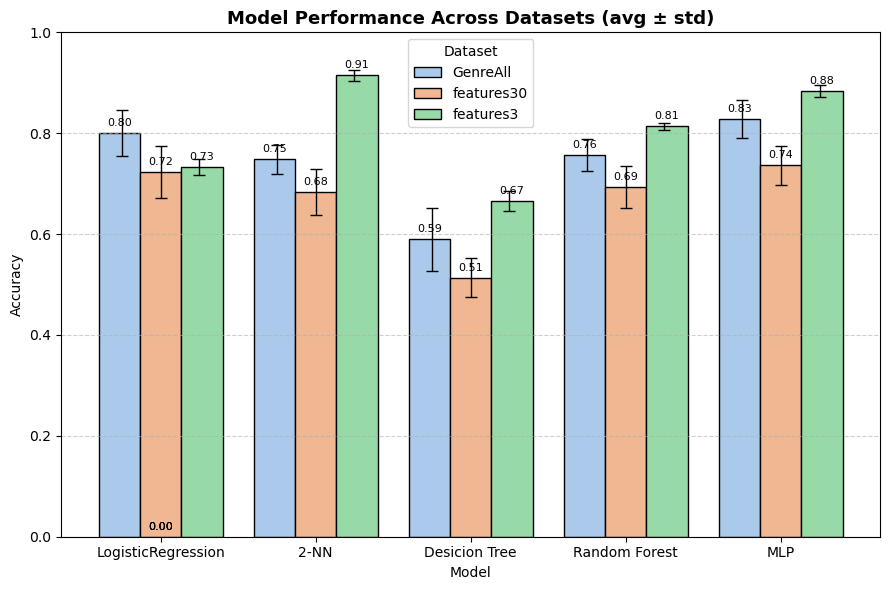

In [31]:

import seaborn as sns


plt.figure(figsize=(9, 6))
sns.barplot(
    data=df, x='Model', y='Avg Accuracy', hue='Dataset',
    palette='pastel', edgecolor='k', errorbar=None
)


# Add manual error bars
for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        mean = df[(df['Model'] == model) & (df['Dataset'] == dataset)]['Avg Accuracy'].values[0]
        std = df[(df['Model'] == model) & (df['Dataset'] == dataset)]['Std'].values[0]
        plt.errorbar(
            x=i + (j - 1)*0.25,  # offset each dataset’s bar horizontally
            y=mean, yerr=std, fmt='none', ecolor='k', capsize=4, elinewidth=1
        )
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width()/2, p.get_height() + 0.01,
             f'{p.get_height():.2f}', ha='center', va='bottom', fontsize=8)


plt.title('Model Performance Across Datasets (avg ± std)', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()


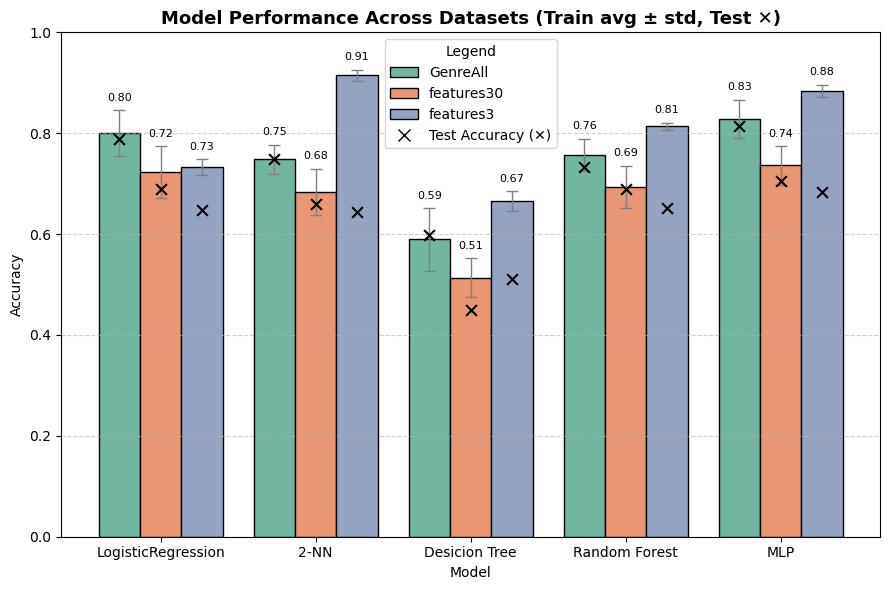

In [36]:
plt.figure(figsize=(9, 6))
sns.barplot(data=df, x='Model', y='Avg Accuracy', hue='Dataset',
            palette='Set2', edgecolor='k', errorbar=None)

# Add manual error bars + test markers + improved labels
bar_width = 0.8 / len(datasets)  # width of each subgroup bar
x_positions = np.arange(len(models))

for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        subset = df[(df['Model'] == model) & (df['Dataset'] == dataset)]
        mean = subset['Avg Accuracy'].values[0]
        std = subset['Std'].values[0]
        test = subset['TestAcc'].values[0]

        # Calculate the x position for this bar
        x_pos = i - 0.4 + bar_width/2 + j * bar_width

        # Error bar
        plt.errorbar(
            x=x_pos, y=mean, yerr=std,
            fmt='none', ecolor='grey', capsize=4, elinewidth=1
        )

        # Test score marker (✕)
        plt.scatter(
            x_pos, test, color='black', marker='x', s=60, zorder=3, label=None
        )

        # Accuracy label (slightly above the error bar to avoid overlap)
        plt.text(
            x_pos, mean + std + 0.015,  # 0.015 offset avoids overlap
            f'{mean:.2f}', ha='center', va='bottom', fontsize=8
        )




# Custom legend handle for test values
test_marker = plt.Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=8, label='Test Accuracy (✕)')

# Title and style
plt.title('Model Performance Across Datasets (Train avg ± std, Test ✕)', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Combine dataset legend + test marker
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + [test_marker], labels + ['Test Accuracy (✕)'], title='Legend')

plt.tight_layout()
plt.show()